# Using load_ard to load and cloud mask multiple satellite sensors <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)

## Description
This notebook demonstrates how to use the `load_ard` function to import a time series of cloud-free observations from either multiple Landsat (i.e. Landsat 5, 7 and 8) or Sentinel-2 satellites (i.e. Sentinel-2A and 2B).
The function will automatically apply pixel quality masking (e.g. cloud masking) or contiguity masking to the input data and returns all available data from multiple sensors as a single combined `xarray.Dataset`.

Optionally, the function can be used to return only observations that contain a minimum proportion of good quality, non-cloudy or shadowed pixels.
This can be used to extract visually appealing time series of observations that are not affected by cloud.

The function supports the following products:

Landsat (GA Collection 3):

* `ga_ls5t_ard_3`, `ga_ls7e_ard_3`, `ga_ls8c_ard_3`

Sentinel-2 Definitive:

* `s2a_ard_granule`, `s2b_ard_granule`

Sentinel-2 Near Real Time:

* `s2a_nrt_granule`, `s2b_nrt_granule`


This notebook demonstrates how to use `load_ard` to:

1. Load and combine Landsat 5, 7 and 8 data into a single `xarray.Dataset`
2. Optionally apply a cloud mask to the resulting data
3. Filter resulting data to keep only cloud-free observations
4. Discard Landsat 7 SLC-off failure data
5. Filter data before loading using a custom function
4. Load and combine Sentinel-2A and Sentinel-2B data into a single `xarray.Dataset`
5. Lazily load data using Dask

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb

### Connect to the datacube


In [2]:
dc = datacube.Datacube(app='Using_load_ard')

## Loading multiple Landsat sensors
The `load_ard` function can be used to load a single, combined timeseries of cloud-masked data from multiple `DEA` products or satellite sensors. 
At its simplest, you can use the function similarly to `dc.load` by passing a set of spatiotemporal query parameters (e.g. `x`, `y`, `time`, `measurements`, `output_crs`, `resolution`, `group_by` etc) directly into the function ([see the dc.load documentation for all possible options](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html)). 
The key difference from `dc.load` is that `load_ard` also requires an existing `Datacube` object, which is passed using the `dc` parameter. 
This gives us the flexibilty to load data from development or experimental datacubes.

In the examples below, we load a single band of data (`nbart_green`) from the three Landsat Collection 3 products (Landsat 5, 7 and 8) by specifying: `products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3']`.
The function always outputs the number of observations for each product, and the total number loaded.
For the following examples, the function output shows that 0 Landsat 5 observations, 11 Landsat 7 observations, and 12 Landsat 8 observations were loaded, for a combined total of 23 observations.

### Explicit syntax
The following example demonstrates how key parameters can be passed directly to `load_ard`.

In [3]:
# Load available data from all three Landsat satellites
ds = load_ard(dc=dc,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              x=(149.06, 149.17),
              y=(-35.27, -35.32),
              time=('2020-09', '2020-10'),
              measurements=['nbart_green'],
              output_crs='EPSG:3577',
              resolution=(-30, 30),
              group_by='solar_day')

# Print output data
ds


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Loading 15 time steps


CPLReleaseMutex: Error = 1 (Operation not permitted)


<xarray.Dataset>
Dimensions:      (time: 15, y: 229, x: 356)
Coordinates:
  * time         (time) datetime64[ns] 2020-09-03T23:56:39.275670 ... 2020-10...
  * y            (y) float64 -3.955e+06 -3.955e+06 ... -3.962e+06 -3.962e+06
  * x            (x) float64 1.544e+06 1.544e+06 ... 1.554e+06 1.554e+06
    spatial_ref  int32 3577
Data variables:
    nbart_green  (time, y, x) float32 667.0 693.0 697.0 685.0 ... nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Query syntax
The following example demonstrates how key parameters can be stored in a `query` dictionary, to be passed as a single parameter to `load_ard`.
The `query` can then be reused in other `load_ard` calls.

In [4]:
# Create a reusable query
query = {
    'x': (149.06, 149.17),
    'y': (-35.27, -35.32),
    'time': ('2020-09', '2020-10'),
    'measurements': ['nbart_green', 'nbart_red', 'nbart_blue'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from all three Landsat satellites
ds = load_ard(dc=dc,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              **query)

# Print output data
ds

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Loading 15 time steps


<xarray.Dataset>
Dimensions:      (time: 15, y: 229, x: 356)
Coordinates:
  * time         (time) datetime64[ns] 2020-09-03T23:56:39.275670 ... 2020-10...
  * y            (y) float64 -3.955e+06 -3.955e+06 ... -3.962e+06 -3.962e+06
  * x            (x) float64 1.544e+06 1.544e+06 ... 1.554e+06 1.554e+06
    spatial_ref  int32 3577
Data variables:
    nbart_green  (time, y, x) float32 667.0 693.0 697.0 685.0 ... nan nan nan
    nbart_red    (time, y, x) float32 602.0 620.0 625.0 609.0 ... nan nan nan
    nbart_blue   (time, y, x) float32 443.0 441.0 444.0 423.0 ... nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Working with cloud masking
By plotting a time slice from the data we loaded above, you can see an area of white pixels where clouds have been masked out and set to `NaN`:

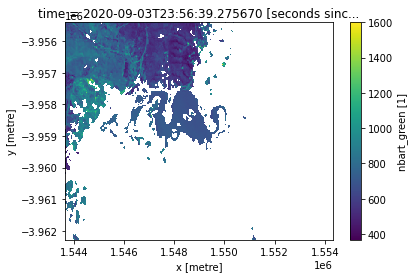

In [5]:
# Plot single observation
ds.isel(time=0).nbart_green.plot()
plt.show()

By default, `load_ard` applies a pixel quality mask to loaded data using the `fmask` band. 
The default mask is created based on `fmask` categories `['valid', 'snow', 'water']` which will preserve non-cloudy or shadowed land, snow and water pixels, and set all invalid, cloudy or shadowy pixels to `NaN`. 
This can be customised using the `fmask_categories` parameter.
To deactive cloud masking completely, set `mask_pixel_quality=False`:

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Loading 15 time steps


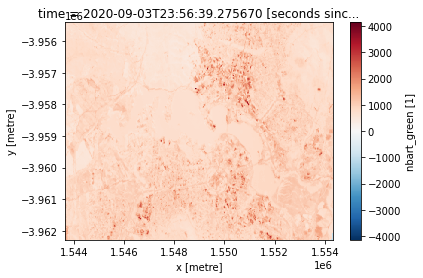

In [6]:
# Load available data with cloud masking deactivated
ds_cloudy = load_ard(
    dc=dc,
    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
    mask_pixel_quality=False,
    **query)

# Plot single observation
ds_cloudy.isel(time=0).nbart_green.plot();

### Filtering to non-cloudy observations
In addition to masking out cloud, `load_ard` allows you to discard any satellite observation that contains less than a minimum proportion of good quality (e.g. non-cloudy) pixels.
This can be used to obtain a time series of only clear, cloud-free observations.

To discard all observations with less than `X`% good quality pixels, use the `min_gooddata` parameter. 
For example, `min_gooddata=0.99` will return only observations where less than 1% of pixels contain cloud, cloud shadow or other invalid data, resulting in a smaller number of clear, cloud free images being returned by the function:

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 1 out of 15 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps


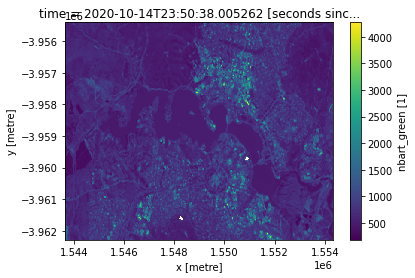

In [7]:
# Load available data filtered to 99% clear observations
ds_noclouds = load_ard(
    dc=dc,
    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
    min_gooddata=0.99,
    **query)

# Plot single observation
ds_noclouds.isel(time=0).nbart_green.plot();

## Applying morphological processing on the cloud mask

There are significant known limitations to the cloud masking algorithms employed by Sentinel-2 and Landsat. 
For example, bright objects like buildings and coastlines are commonly mistaken for cloud. 
We can improve on the false positives detected by Landsat and Sentinel-2's pixel quality mask by applying binary morphological image processing techniques (e.g. [binary_closing](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.morphology.binary_closing.html#scipy.ndimage.morphology.binary_closing), [binary_erosion](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.morphology.binary_erosion.html#scipy.ndimage.morphology.binary_erosion) etc.). 
The Open Data Cube library [odc-algo](https://github.com/opendatacube/odc-tools/tree/develop/libs/algo) has a function `odc.algo.mask_cleanup` that can perform a few of these operations. Below, we will try to improve the cloud mask by apply a number of these filters.

Feel free to experiment with the values in `filters`.


In [8]:
# Set the filters to apply
filters = [("opening", 4), ("dilation", 2)]

# Load data
ds_filtered = load_ard(
    dc=dc,
    products=["ga_ls5t_ard_3", "ga_ls7e_ard_3", "ga_ls8c_ard_3"],
    mask_filters=filters,
    **query)

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying morphological filters to pixel quality mask: [('opening', 4), ('dilation', 2)]
Applying pixel quality/cloud mask
Loading 15 time steps


Below, you may notice that in the second image the cloud mask is cleaner and less noisy.

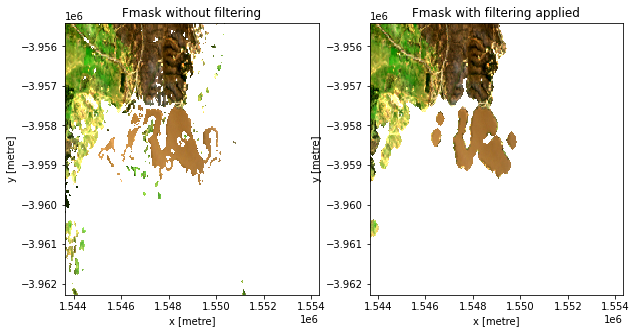

In [9]:
# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
rgb(ds, index=0, ax=ax[0])
rgb(ds_filtered, index=0, ax=ax[1])
ax[0].set_title('Fmask without filtering')
ax[1].set_title('Fmask with filtering applied');

### Discarding Landsat 7 SLC-off failure data
On [May 31 2003, Landsat 7's Scan Line Corrector (SLC) that compensated for the satellite's forward motion failed](http://usgs.gov/land-resources/nli/landsat/landsat-7), introducing linear data gaps in all subsequent Landsat 7 observations. 
For example, the following Landsat 7 image contains visible striping:

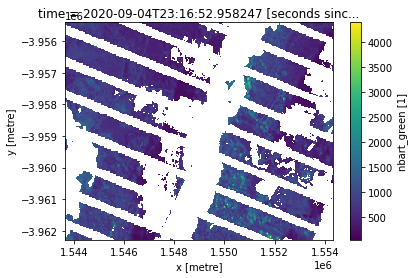

In [10]:
# Plot Landsat data
ds.isel(time=1).nbart_green.plot()

Although this data still contains valuable information, for some applications (e.g. generating clean composites from multiple images) it can be useful to discard Landsat 7 imagery acquired after the SLC failure.
This data is known as "SLC-off" data.

This can be achieved using `load_ard` using the `ls7_slc_off`. 
By default this is set to `ls7_slc_off=True` which will include all SLC-off data.
Set to `ls7_slc_off=False` to discard this data instead; observe that the function now reports that it is ignoring SLC-off observations:

```
Finding datasets
    ga_ls5t_ard_3 
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
 ```


In [11]:
# Load available data after discarding Landsat 7 SLC-off data
ds = load_ard(dc=dc, 
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              ls7_slc_off=False,
              **query)

# Print output data
ds

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Loading 8 time steps


<xarray.Dataset>
Dimensions:      (time: 8, y: 229, x: 356)
Coordinates:
  * time         (time) datetime64[ns] 2020-09-03T23:56:39.275670 ... 2020-10...
  * y            (y) float64 -3.955e+06 -3.955e+06 ... -3.962e+06 -3.962e+06
  * x            (x) float64 1.544e+06 1.544e+06 ... 1.554e+06 1.554e+06
    spatial_ref  int32 3577
Data variables:
    nbart_green  (time, y, x) float32 667.0 693.0 697.0 685.0 ... nan nan nan
    nbart_red    (time, y, x) float32 602.0 620.0 625.0 609.0 ... nan nan nan
    nbart_blue   (time, y, x) float32 443.0 441.0 444.0 423.0 ... nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Filtering data before load using a custom function

The `load_ard` function has a powerful `predicate` parameter that allows you to filter out satellite observations before they are actually loaded using a custom function. 
Some examples of where this may be useful include:

* Filtering to return data from a specific season (e.g. summer, winter)
* Filtering to return data acquired on a particular day of the year
* Filtering to return data based on an external dataset (e.g. data acquired during specific climatic conditions such as drought or flood)

A predicate function should take a `datacube.model.Dataset` object as an input (e.g. as returned from `dc_landsat.find_datasets(product='ga_ls8c_ard_3', **query)[0]`), and return either `True` or `False`.
For example, a predicate function could be used to return `True` for only datasets acquired in September: 

`dataset.time.begin.month == 9`

In the example below, we create a simple predicate function that will filter our data to return only satellite data acquired in September:

In [12]:
# Simple function that returns True if month is September
def filter_sep(dataset):
    return dataset.time.begin.month == 9

# Load data that passes the `filter_sep` function
ds = load_ard(dc=dc, 
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              predicate=filter_sep,                
              **query)

# Print output data
ds

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Filtering datasets using predicate function
Applying pixel quality/cloud mask
Loading 8 time steps


<xarray.Dataset>
Dimensions:      (time: 8, y: 229, x: 356)
Coordinates:
  * time         (time) datetime64[ns] 2020-09-03T23:56:39.275670 ... 2020-09...
  * y            (y) float64 -3.955e+06 -3.955e+06 ... -3.962e+06 -3.962e+06
  * x            (x) float64 1.544e+06 1.544e+06 ... 1.554e+06 1.554e+06
    spatial_ref  int32 3577
Data variables:
    nbart_green  (time, y, x) float32 667.0 693.0 697.0 ... 639.0 669.0 650.0
    nbart_red    (time, y, x) float32 602.0 620.0 625.0 ... 548.0 547.0 600.0
    nbart_blue   (time, y, x) float32 443.0 441.0 444.0 ... 411.0 426.0 435.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

We can print the time steps returned by `load_ard` to verify that they now include only September observations (e.g. `2018-09-...`):

In [13]:
ds.time.values

array(['2020-09-03T23:56:39.275670000', '2020-09-04T23:16:52.958247000',
       '2020-09-11T23:22:35.911983000', '2020-09-12T23:50:31.863003000',
       '2020-09-19T23:56:44.894850000', '2020-09-20T23:15:48.989473000',
       '2020-09-27T23:21:33.061255000', '2020-09-28T23:50:36.264585000'],
      dtype='datetime64[ns]')

### Filter to a single season
An example of a predicate function that will return data from a season of interest would look as follows:

    def seasonal_filter(dataset, season=[12, 1, 2]):    
            #return true if month is in defined season 
            return dataset.time.begin.month in season

After applying this predicate function, running the following command demonstrates that our dataset only contains months during the Dec, Jan, Feb period

    ds.time.dt.season :

    <xarray.DataArray 'season' (time: 37)>
    array(['DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
           'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
           'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
           'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF',
           'DJF'], dtype='<U3')
    Coordinates:
      * time     (time) datetime64[ns] 2016-01-05T10:27:44.213284 ... 2017-12-26T10:23:43.129624

## Loading Sentinel-2 data
Data from the Sentinel-2A and Sentinel-2B satellites can also be loaded using `load_ard`. 
To do this, we need to specify Sentinel-2 products in place of the Landsat products above.

The `query` parameter can be reused to load Sentinel-2 data for the same specifcations used for the Landsat data above:

In [14]:
# Load available data from both Sentinel 2 satellites
ds = load_ard(dc=dc,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              **query)

# Print output data
ds


Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Applying pixel quality/cloud mask
Loading 12 time steps


<xarray.Dataset>
Dimensions:      (time: 12, y: 229, x: 356)
Coordinates:
  * time         (time) datetime64[ns] 2020-09-01T00:06:35.143492 ... 2020-10...
  * y            (y) float64 -3.955e+06 -3.955e+06 ... -3.962e+06 -3.962e+06
  * x            (x) float64 1.544e+06 1.544e+06 ... 1.554e+06 1.554e+06
    spatial_ref  int32 3577
Data variables:
    nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

Cloudy pixels are masked out by default from the resulting observations similarly to Landsat:

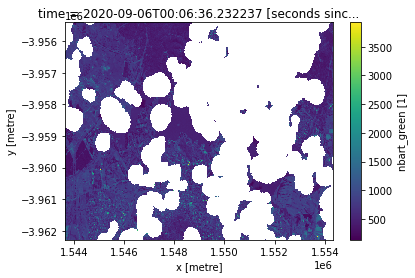

In [15]:
# Plot single observation
ds.isel(time=1).nbart_green.plot();

## Lazy loading with Dask

Rather than load data directly - which can take a long time and large amounts of memory - all datacube data can be lazy loaded using `Dask`.
This can be a very useful approach for when you need to load large amounts of data without crashing your analysis, or if you want to subsequently scale your analysis by distributing tasks in parallel across multiple workers. 

The `load_ard` function can be easily adapted to lazily load data rather than loading it into memory by providing a `dask_chunks` parameter using either the [explicit](#Explicit-syntax) or [query](#Query-syntax) syntax.
The minimum required to lazily load data is `dask_chunks={}`, but chunking can also be performed spatially (e.g. `dask_chunks={'x': 1000, 'y': 1000}`) or by time (e.g. `dask_chunks={'time': 1}`) depending on the analysis being conducted.

> **Note:** For more information about using Dask, refer to the [Parallel processing with Dask](07_Parallel_processing_with_Dask.ipynb) notebook.

In [16]:
# Lazily load available Sentinel 2 data
ds = load_ard(dc=dc,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              dask_chunks={},
              **query)

# Print output data
ds

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Applying pixel quality/cloud mask
Returning 12 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 12, y: 229, x: 356)
Coordinates:
  * time         (time) datetime64[ns] 2020-09-01T00:06:35.143492 ... 2020-10...
  * y            (y) float64 -3.955e+06 -3.955e+06 ... -3.962e+06 -3.962e+06
  * x            (x) float64 1.544e+06 1.544e+06 ... 1.554e+06 1.554e+06
    spatial_ref  int32 3577
Data variables:
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 229, 356), meta=np.ndarray>
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 229, 356), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 229, 356), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

Note that the data loads almost instantaneously, and that that each of the arrays listed under `Data variables` are now described as `dask.arrays`.
To load the data into memory, you can run:

In [17]:
ds.compute()

<xarray.Dataset>
Dimensions:      (time: 12, y: 229, x: 356)
Coordinates:
  * time         (time) datetime64[ns] 2020-09-01T00:06:35.143492 ... 2020-10...
  * y            (y) float64 -3.955e+06 -3.955e+06 ... -3.962e+06 -3.962e+06
  * x            (x) float64 1.544e+06 1.544e+06 ... 1.554e+06 1.554e+06
    spatial_ref  int32 3577
Data variables:
    nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2022

**Compatible datacube version:** 

In [18]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)